### Climate Data Time-Series
We will be using Jena Climate dataset recorded by the Max Planck Institute for Biogeochemistry. The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per 10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016

Get the dataset from:
https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip


### Import packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
df = pd.read_csv('jena_climate_2009_2016.csv')
print("number of inputs : ", len(df.index))
df.head()

number of inputs :  420551


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


### Visualization of features over the time (2009 - 2016)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:66: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


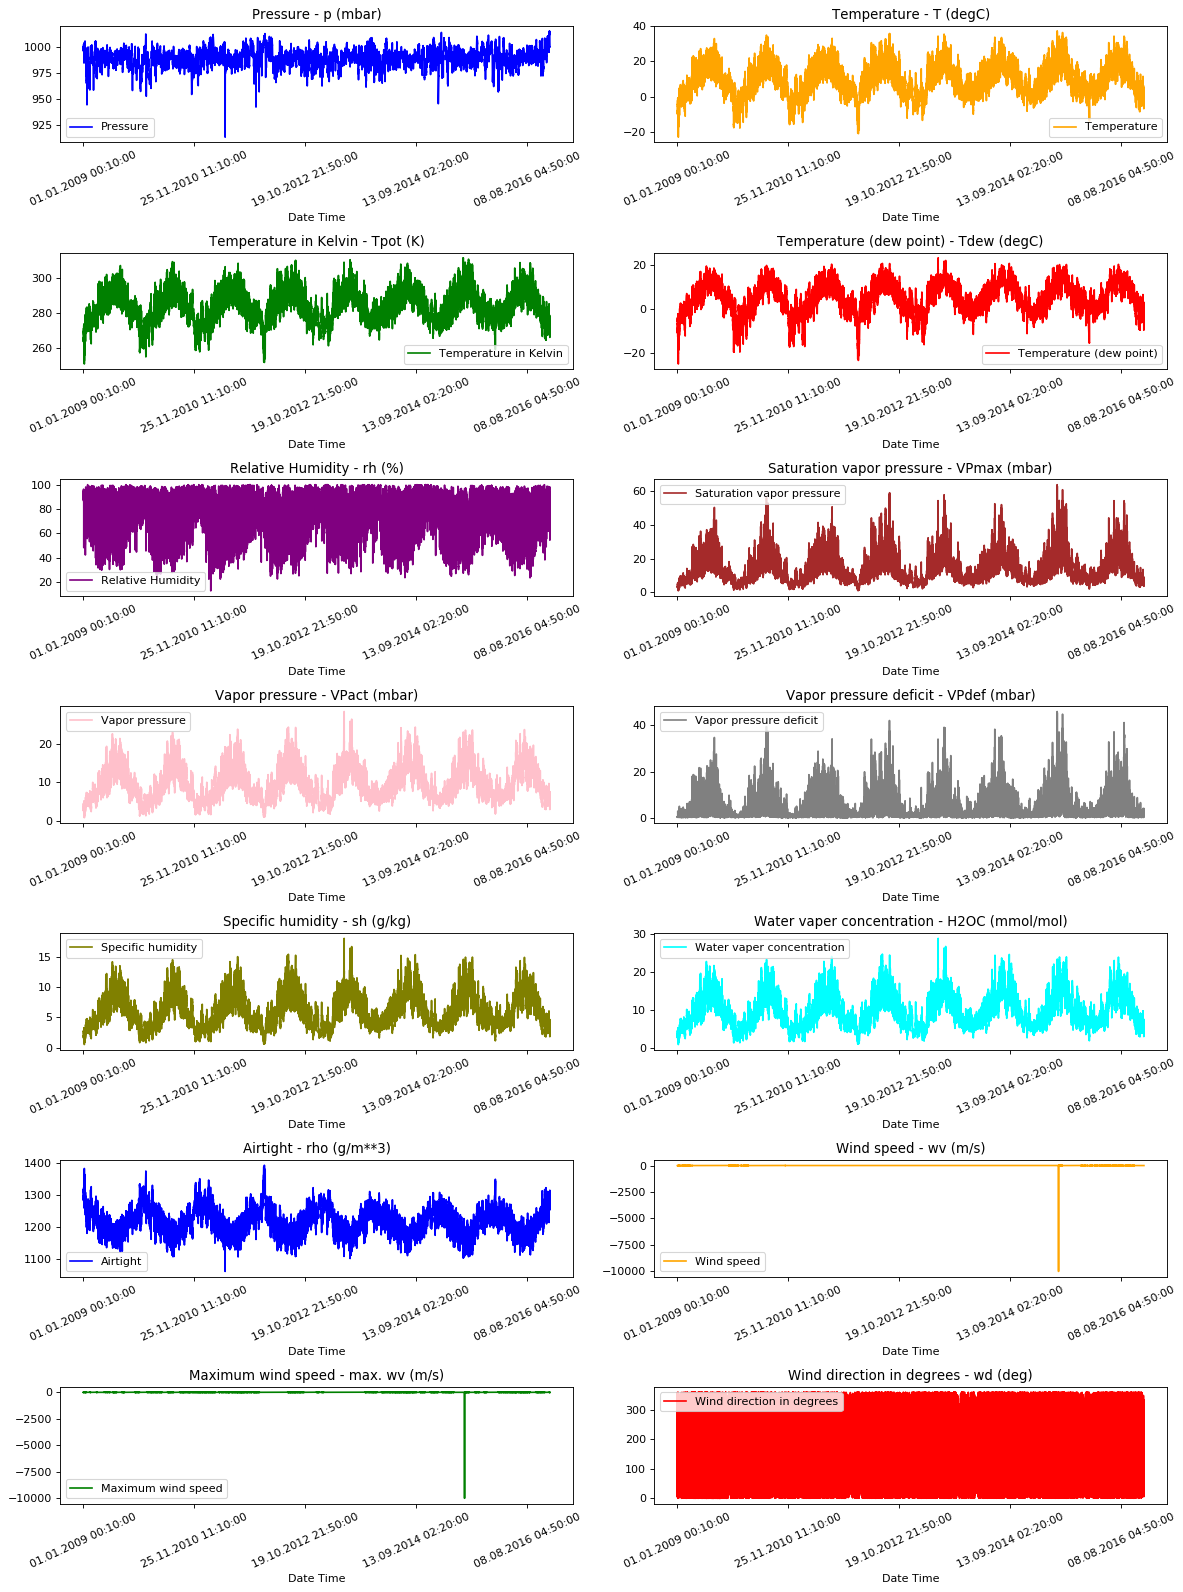

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vaper concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees"
]

features = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)"
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

time = "Date Time"

def show_feature_over_time(dataframe):
    time_data = dataframe[time]
    fig, axes = plt.subplots(
            nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i, feature in enumerate(features):
        color = colors[i % len(colors)]
        feat_data = dataframe[feature]
        feat_data.index = time_data
        ax = feat_data.plot(
            ax=axes[i // 2, i % 2],
            color=color,
            title="{} - {}".format(titles[i], feature),
            rot=25
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    
show_feature_over_time(df)

### Data Preprocessing
Observation is recorded every 10 mins, that means 6 times per hour. We will resample one point per hour since no drastic change is expected within 60 minutes. 

We are tracking data from past 720 timestamps (720 observations/6 = 120 hours = 5 days). This data will be used to predict the temperature after 72 timestamps (76/6=12 hours).

The model is shown data for first 5 days i.e. 720 observations, that are sampled every hour (120 observations). The temperature after 72 (12 hours * 6 observation per hour) observation will be used as a label.


In [5]:
split_fraction = 0.8
train_split = int(split_fraction * int(df.shape[0]))

step = 6 # 1 hour

past = 720 # 5 days
future = 72 # 12 hours

def normalize(data, train_split):
    data_max = data[:train_split].max(axis=0)
    data_min = data[:train_split].min(axis=0)
    return (data - data_min) / (data_max - data_min)

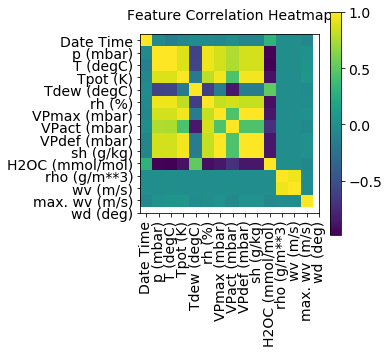

In [6]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
    
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

In [7]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [features[i] for i in [0, 1, 5, 7, 8, 10, 11]]
print("selected features : ", selected_features)
inputs = df[selected_features]
inputs.index = df[time]
inputs.head()

inputs = normalize(inputs.values, train_split)
inputs = pd.DataFrame(inputs)
inputs.head()

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed
selected features :  ['p (mbar)', 'T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'rho (g/m**3)', 'wv (m/s)']


,0,1,2,3,4,5,6
0,0.826390,0.254629,0.040985,0.005223,0.081679,0.743213,0.070403
1,0.826889,0.248004,0.039263,0.004986,0.078843,0.749349,0.049214
2,0.826490,0.246305,0.038919,0.004748,0.078276,0.750666,0.012987
3,0.826291,0.249703,0.039780,0.004511,0.080545,0.747523,0.023240
4,0.826291,0.250382,0.039952,0.004511,0.080545,0.746954,0.021873


In [18]:
train_data = inputs.loc[0 : train_split - 1]
val_data = inputs.loc[train_split:]
print(train_data.shape)
print(val_data.shape)

(336440, 7)
(84111, 7)


### Training dataset
The training dataset labels starts from the 792nd observation (720 + 72).

In [20]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = inputs.iloc[start:end][[1]]

sequence_length = int(past / step)

print("x_train shape : ", x_train.shape)
print("y_train shape : ", y_train.shape)
print("sequence length : ", sequence_length)

x_train shape :  (336440, 7)
y_train shape :  (336440, 1)
sequence length :  120


In [21]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=256
)

In [22]:
for batch in dataset_train.take(1):
    train, target = batch
print(train.shape)
print(target.shape)

(256, 120, 7)
(256, 1)


In [23]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = inputs.iloc[label_start:][[1]]

print("x_val shape : ", x_val.shape)
print("y_val shape : ", y_val.shape)

x_val shape :  (83319, 7)
y_val shape :  (83319, 1)


In [24]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=256,
)

### Build the model

In [25]:
model_input = keras.layers.Input(shape=(train.shape[1], train.shape[2]))
lstm_out = keras.layers.LSTM(32)(model_input)
model_output = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=model_input, outputs=model_output)
model.compile()

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                          patience=5)

history = model.fit(dataset_train, epochs=10,
                   validation_data=dataset_val,
                   callbacks=[early_stop])

Epoch 1/10


ValueError: in user code:

    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:837 train_function  *
        return step_function(self, iterator)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:827 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1263 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2735 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3424 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:820 run_step  **
        outputs = model.train_step(data)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:533 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:633 apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    /home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/utils.py:79 filter_empty_gradients
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['lstm_1/lstm_cell_1/kernel:0', 'lstm_1/lstm_cell_1/recurrent_kernel:0', 'lstm_1/lstm_cell_1/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0'].
